In [150]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.arima_model import ARIMA

import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [46]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y %H:%M:%S')
# df = pd.read_csv("Microsoft_Stock.csv", parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = pd.read_csv("data/Electric_Production.csv")

In [47]:
df.head()

,DATE,value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151


In [48]:
for i in df.columns:
    print("The number of NaA in {} is {}".format(i, df[i].isnull().sum()))

The number of NaA in DATE is 0
The number of NaA in value is 0


In [5]:
# df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %H:%M:%S')

In [50]:
df.DATE = pd.to_datetime(df.DATE)

In [51]:
df.index = df.DATE

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    397 non-null    datetime64[ns]
 1   value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.3 KB


In [53]:
df.shape

(397, 2)

In [54]:
df.head()

,DATE,value
DATE,,
1985-01-01,1985-01-01,72.5052
1985-02-01,1985-02-01,70.6720
1985-03-01,1985-03-01,62.4502
1985-04-01,1985-04-01,57.4714
1985-05-01,1985-05-01,55.3151


In [55]:
train = df.iloc[:250]
test = df.iloc[250:]

In [56]:
test.iloc[0]

DATE     2005-11-01 00:00:00
value                90.4587
Name: 2005-11-01 00:00:00, dtype: object

## Predict "Volume"

In [57]:
ts_train = train.value
ts_test = test.value

In [58]:
# check the stationary of data
ts_adf = ADF(ts_train.tolist())
ts_adf

(-0.6812165212472877,
 0.8515550775344071,
 12,
 237,
 {'1%': -3.4582467982399105,
  '5%': -2.8738137461081323,
  '10%': -2.5733111490323846},
 1051.0884525079348)

In [59]:
ts_diff1 = ts_train.diff(1)
ts_diff1 = ts_diff1.fillna(0)
ts_adf_diff1 = ADF(ts_diff1.tolist())
ts_adf_diff1

(-7.930717202582098,
 3.5192303372058674e-12,
 11,
 238,
 {'1%': -3.458128284586202,
  '5%': -2.873761835239286,
  '10%': -2.5732834559706235},
 1050.0492043973118)

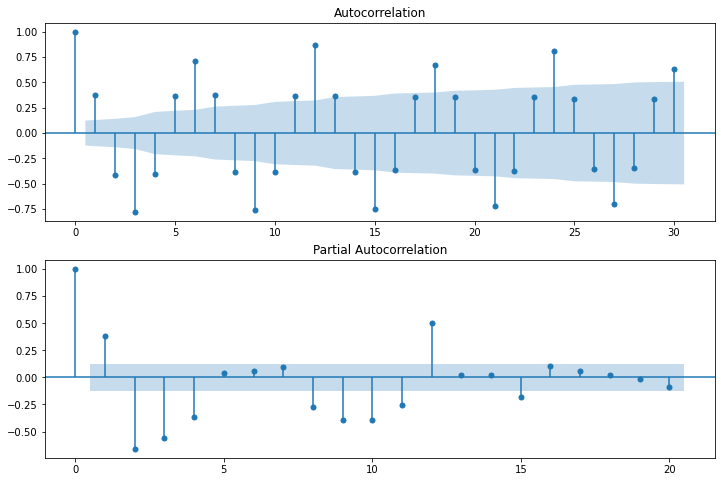

In [64]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211) 
sm.graphics.tsa.plot_acf(ts_diff1, lags=30, ax=ax1) 
ax2 = fig.add_subplot(212) 
sm.graphics.tsa.plot_pacf(ts_diff1, lags=20, ax=ax2) 
plt.show()

In [63]:
train_results = sm.tsa.arma_order_select_ic(ts_diff1, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (3, 4)
BIC (3, 3)


In [65]:
## AR(p=2)
model = sm.tsa.ARIMA(ts_train, order=(3, 1, 4))
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47670D+00    |proj g|=  6.43835D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      1     21      1     0     0   6.438D+05   2.477D+00
  F =   2.4767029137365015     

ABNORMAL_TERMINATION_IN_LNSRCH                              


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


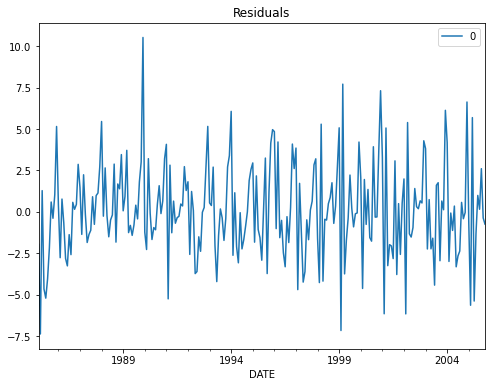

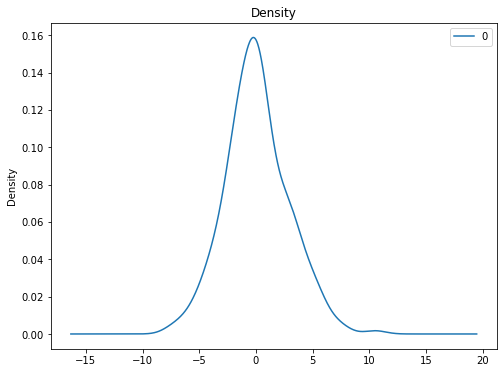

In [66]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
fig1, ax1 = plt.subplots(figsize=(8,6))
residuals.plot(title="Residuals", ax=ax1)
fig2, ax2 = plt.subplots(figsize=(8,6))
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

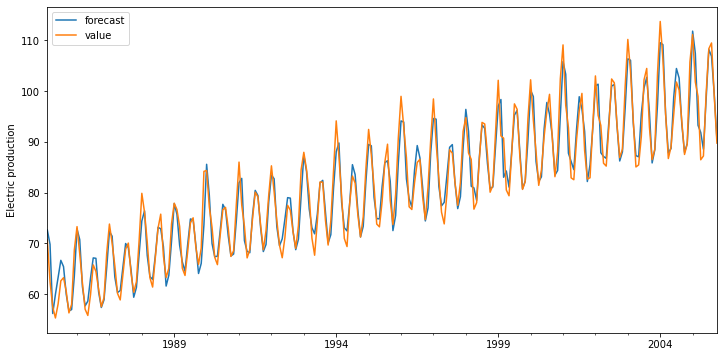

In [67]:
fig3, ax3 = plt.subplots(figsize=(12,6))
model_fit.plot_predict(dynamic=False, ax=ax3)
plt.ylabel("Electric production")
plt.show()

In [68]:
ts_test

DATE
2005-11-01     90.4587
2005-12-01    108.2257
2006-01-01    104.4724
2006-02-01    101.5196
2006-03-01     98.4017
                ...   
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048
Name: value, Length: 147, dtype: float64

In [69]:
predict = model_fit.forecast(steps=147, alpha=0.05)[0]

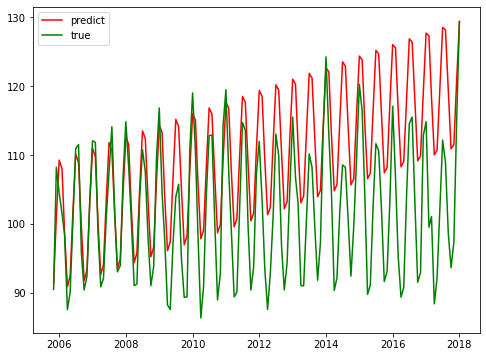

In [72]:
plt.figure(figsize=(8,6))
plt.plot(ts_test.index, predict, label='predict', color='red')
plt.plot(ts_test.index, ts_test.values, label='true', color='green')
plt.legend()
plt.show()

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

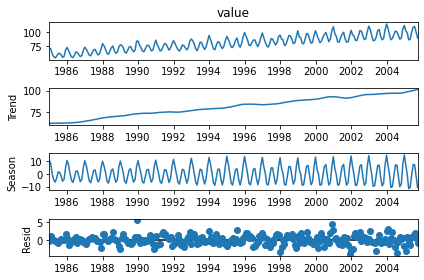

In [201]:
result = STL(ts_train, period=12).fit()
result.plot()
plt.show()

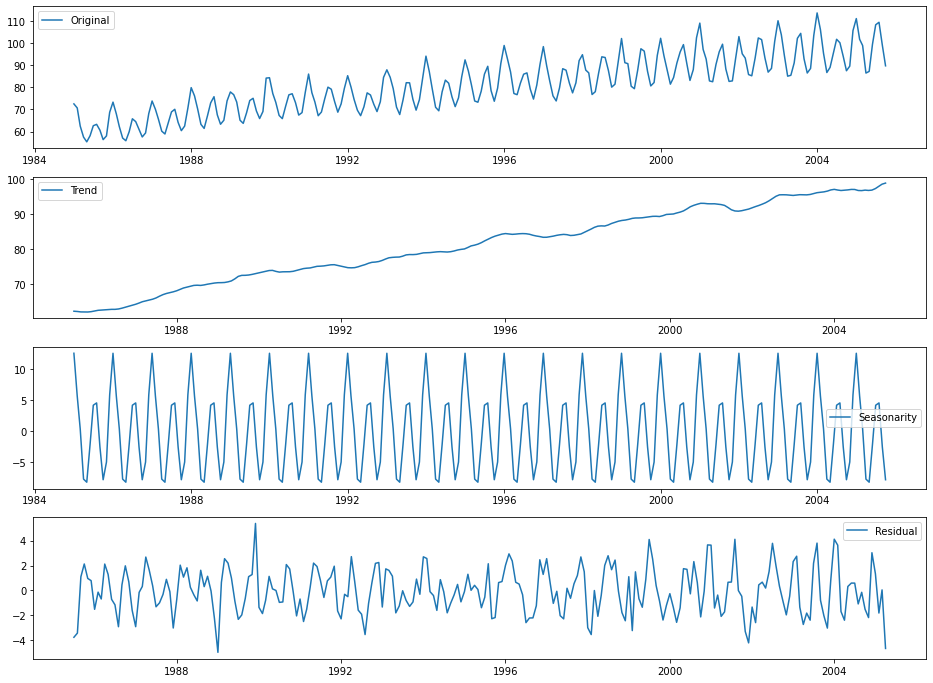

In [170]:
decomposition = seasonal_decompose(ts_train) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 12)) 
plt.subplot(411)
plt.plot(ts_train, label='Original') 
plt.legend(loc='best') 
plt.subplot(412)
plt.plot(trend, label='Trend') 
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonarity') 
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual') 
plt.legend(loc='best')
plt.show()

In [173]:
trend2 = trend.dropna()

In [174]:
trend2

DATE
1985-07-01    62.199021
1985-08-01    62.120496
1985-09-01    61.999112
1985-10-01    61.971337
1985-11-01    61.973842
                ...    
2004-12-01    96.832721
2005-01-01    97.272654
2005-02-01    97.932612
2005-03-01    98.531579
2005-04-01    98.836662
Name: trend, Length: 238, dtype: float64

In [151]:
trend = trend.fillna(np.mean(trend))
ADF(trend.tolist())

(-1.2752127642149147,
 0.6404348466303479,
 0,
 249,
 {'1%': -3.4568881317725864,
  '5%': -2.8732185133016057,
  '10%': -2.5729936189738876},
 738.709624275873)

In [175]:
trend_diff1 = trend2.diff(1)
trend_diff1 = trend_diff1.fillna(0)
ADF(trend_diff1.tolist())

(-4.472247202108629,
 0.00022063613468343204,
 15,
 222,
 {'1%': -3.460154163751041,
  '5%': -2.874648939216792,
  '10%': -2.5737567259151044},
 -402.45847897515705)

In [186]:
trend_diff2 = trend_diff1.diff(1)
trend_diff2 = trend_diff2.fillna(0)
ADF(trend_diff2.tolist())

(-7.127162852143574,
 3.595275485012728e-10,
 15,
 222,
 {'1%': -3.460154163751041,
  '5%': -2.874648939216792,
  '10%': -2.5737567259151044},
 -390.70930212759527)

In [196]:
residual = residual.fillna(0)
ADF(residual.tolist())

(-7.3342921772808,
 1.1069242398762823e-10,
 14,
 235,
 {'1%': -3.4584868856997004,
  '5%': -2.873918902362675,
  '10%': -2.573367247623359},
 852.9527500974348)

In [142]:
seasonal = seasonal.fillna(0)
ADF(seasonal.tolist())

(-6248306509379516.0,
 0.0,
 16,
 233,
 {'1%': -3.458731141928624,
  '5%': -2.8740258764297293,
  '10%': -2.5734243167124093},
 -14617.75699684037)

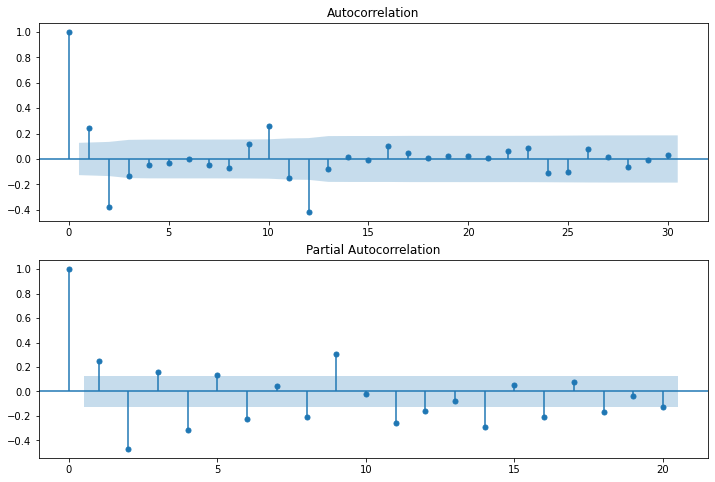

In [187]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211) 
sm.graphics.tsa.plot_acf(trend_diff2, lags=30, ax=ax1) 
ax2 = fig.add_subplot(212) 
sm.graphics.tsa.plot_pacf(trend_diff2, lags=20, ax=ax2) 
plt.show()

In [188]:
train_results = sm.tsa.arma_order_select_ic(trend_diff2, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 4)
BIC (1, 2)


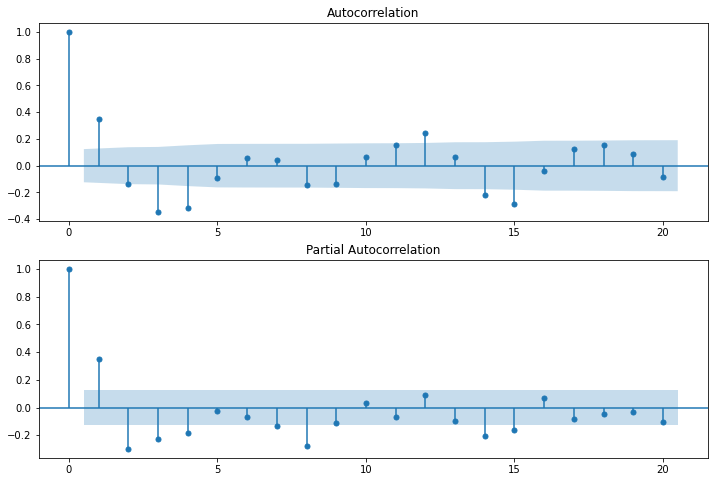

In [155]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211) 
sm.graphics.tsa.plot_acf(residual, lags=20, ax=ax1) 
ax2 = fig.add_subplot(212) 
sm.graphics.tsa.plot_pacf(residual, lags=20, ax=ax2) 
plt.show()

In [104]:
train_results = sm.tsa.arma_order_select_ic(residual, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 4)
BIC (2, 1)


In [156]:
sea_pred_seq = seasonal['1992-11-01':'2005-01-01']

In [157]:
sea_pred_seq.index = ts_test.index

In [113]:
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order) 
    return model.fit()

In [193]:
trend_model = ARIMA_Model(trend2, (1, 2, 2)) 
trend_fit_seq = trend_model.fittedvalues
# trend_predict_seq = trend_model.predict(start='2005-11-01', end='2018-01-01', dynamic=True)
trend_predict_seq = trend_model.forecast(steps=147)[0]

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [194]:
trend_predict_seq

array([ 99.02683969,  99.20243488,  99.36716787,  99.52845539,
        99.68561903,  99.8424906 ,  99.99745595, 100.15291835,
       100.30728774, 100.46226507, 100.61650744, 100.77129161,
       100.92553699, 101.08022629, 101.23450494, 101.38913698,
       101.54345099, 101.69804335, 101.85238784, 102.0069507 ,
       102.1613199 , 102.31586013, 102.47024893, 102.6247716 ,
       102.7791758 , 102.93368477, 103.08810105, 103.24259932,
       103.39702506, 103.55151496, 103.7059481 , 103.86043144,
       104.01487037, 104.16934859, 104.32379206, 104.47826627,
       104.63271329, 104.78718436, 104.94163415, 105.09610276,
       105.25055473, 105.40502142, 105.55947508, 105.71394027,
       105.86839527, 106.02285928, 106.17731532, 106.33177841,
       106.48623526, 106.64069763, 106.79515512, 106.94961692,
       107.10407491, 107.25853628, 107.41299465, 107.56745567,
       107.72191435, 107.8763751 , 108.03083402, 108.18529456,
       108.33975367, 108.49421405, 108.6486733 , 108.80

In [197]:
residual_model = ARIMA_Model(residual, (2, 0, 1))
residual_fit_seq = residual_model.fittedvalues
# residual_predict_seq = residual_model.predict(start='2005-11-01', end='2018-01-01', dynamic=True)
residual_predict_seq = residual_model.forecast(steps=147)[0]

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81185D+00    |proj g|=  8.28241D-02

At iterate    5    f=  1.80627D+00    |proj g|=  1.19614D-01

At iterate   10    f=  1.80167D+00    |proj g|=  1.34955D-02

At iterate   15    f=  1.80093D+00    |proj g|=  3.39568D-02

At iterate   20    f=  1.80082D+00    |proj g|=  1.46505D-04

At iterate   25    f=  1.80082D+00    |proj g|=  4.61027D-03

At iterate   30    f=  1.80082D+00    |proj g|=  1.10134D-03

At iterate   35    f=  1.80082D+00    |proj g|=  1.23346D-04

At iterate   40    f=  1.80082D+00    |proj g|=  3.64153D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [198]:
predict_seq = pd.Series(sea_pred_seq, index=sea_pred_seq.index) 
predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)

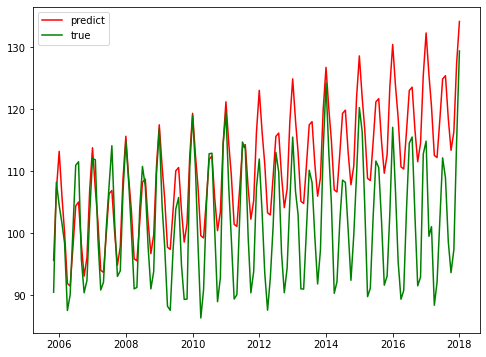

In [199]:
plt.figure(figsize=(8,6))
plt.plot(ts_test.index, predict_seq, label='predict', color='red')
plt.plot(ts_test.index, ts_test.values, label='true', color='green')
plt.legend()
plt.show()

In [127]:
ts_test

DATE
2005-11-01     90.4587
2005-12-01    108.2257
2006-01-01    104.4724
2006-02-01    101.5196
2006-03-01     98.4017
                ...   
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048
Name: value, Length: 147, dtype: float64

In [119]:
sea_pred_seq

DATE
2005-11-01    -4.939321
2005-12-01     5.857908
2006-01-01    12.550671
2006-02-01     5.667152
2006-03-01     0.382881
                ...    
2017-09-01    -2.513291
2017-10-01    -7.784896
2017-11-01    -4.939321
2017-12-01     5.857908
2018-01-01    12.550671
Name: seasonal, Length: 147, dtype: float64